# Reciprocal Relationship between Bartering and Selling
- When it comes to game exchange, do people prefer to exchange the game with someone who has exchanged before or someone who has not exchanged before? 
- What's the difference between game sales and game exchange?

Here, we use logistic regression.

## 0. Load the data

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from pickle file
with open('data/transaction_history_all.pickle', 'rb') as f:
    data_with_user = pickle.load(f)

# Choose only the data before 2019-01-01
data_with_user = data_with_user.loc[data_with_user['created_utc']<='2018-12-31']

In [3]:
with open(("./data/df_pre2019_original.pickle"), 'rb') as handle:
     data_with_original = pickle.load(handle)
data_with_original.head()

,index,author,body,created_utc,permalink,reply_author,reply_body,type,url,created_utc_original
0,mjwright412_0,ACM1899,Sold Mario Kart Double Dash to /u/mjwright412 ...,2016-05-28 15:24:00,/r/GameSale/comments/4c34l2/completed_trade_th...,mjwright412,Confirmed!,gamesale,r/GameSale/comments/4hdn0z,2016-05-02 02:37:22
1,mjwright412_1,TearsOfARapper84,Successful sale of Watch Dogs 2 Gold Edition P...,2016-12-20 18:37:19,/r/GameSale/comments/543odh/completed_trade_th...,mjwright412,"Confirmed. Awesome person, no hassle and would...",gamesale,r/GameSale/comments/5j8grc,2016-12-19 19:47:10
4,rdmentalist_0,Barbecue_Wings,Successfull swap of Rocket League on XB1 for $...,2016-08-30 16:31:14,/r/GameSale/comments/4c34l2/completed_trade_th...,rdmentalist,"Confirmed, thanks",gamesale,r/gameswap/comments/5072ge,2016-08-29 20:15:30
5,rdmentalist_1,wilbursmith22,Completed trade with u/rdmentalist\n\nLast Gua...,2017-06-30 22:40:47,/r/GameSale/comments/6jbqrp/completed_sale_thr...,rdmentalist,"Confirmed, thanks",gamesale,r/gameswap/comments/6k4yms,2017-06-29 00:54:10
6,rdmentalist_2,MrAce2C,Successful trade with u/rdmentalist. Gave Gear...,2016-10-23 21:59:35,/r/gameswap/comments/543ojp/completed_trade_th...,rdmentalist,Confirmed.,gameswap,r/gameswap/comments/5906ut,2016-10-23 19:16:49


In [7]:
data_with_original['user']=data_with_user['user']
data = data_with_original.copy()
data.head()

,index,author,body,created_utc,permalink,reply_author,reply_body,type,url,created_utc_original,user
0,mjwright412_0,ACM1899,Sold Mario Kart Double Dash to /u/mjwright412 ...,2016-05-28 15:24:00,/r/GameSale/comments/4c34l2/completed_trade_th...,mjwright412,Confirmed!,gamesale,r/GameSale/comments/4hdn0z,2016-05-02 02:37:22,mjwright412
1,mjwright412_1,TearsOfARapper84,Successful sale of Watch Dogs 2 Gold Edition P...,2016-12-20 18:37:19,/r/GameSale/comments/543odh/completed_trade_th...,mjwright412,"Confirmed. Awesome person, no hassle and would...",gamesale,r/GameSale/comments/5j8grc,2016-12-19 19:47:10,mjwright412
4,rdmentalist_0,Barbecue_Wings,Successfull swap of Rocket League on XB1 for $...,2016-08-30 16:31:14,/r/GameSale/comments/4c34l2/completed_trade_th...,rdmentalist,"Confirmed, thanks",gamesale,r/gameswap/comments/5072ge,2016-08-29 20:15:30,rdmentalist
5,rdmentalist_1,wilbursmith22,Completed trade with u/rdmentalist\n\nLast Gua...,2017-06-30 22:40:47,/r/GameSale/comments/6jbqrp/completed_sale_thr...,rdmentalist,"Confirmed, thanks",gamesale,r/gameswap/comments/6k4yms,2017-06-29 00:54:10,rdmentalist
6,rdmentalist_2,MrAce2C,Successful trade with u/rdmentalist. Gave Gear...,2016-10-23 21:59:35,/r/gameswap/comments/543ojp/completed_trade_th...,rdmentalist,Confirmed.,gameswap,r/gameswap/comments/5906ut,2016-10-23 19:16:49,rdmentalist


## 1. Preprocessing
- The bot may record wrongly the confirmantion.
- Some Reddit users may delete their accounts.

**We ignore these cases by deleting these rows.**

In [11]:
# Select the rows that have a user that is not deleted.
data = data.loc[~data['user'].isna()]

print("Number of deleted users: ", data.loc[(data['author']=='[deleted]')|(data['reply_author']=='[deleted]')].shape[0])
data = data.loc[(data['author']!='[deleted]') & (data['reply_author']!='[deleted]')]

print("Remaining rows of confirmantion data:", data.shape[0])
# data['created_utc'].describe(datetime_is_numeric=True)

Number of deleted users:  1514


## 2. Relationship

In [13]:
data_sale = data.loc[data['type']=='gamesale']
data_swap = data.loc[data['type']=='gameswap']

swap_user = set(data_swap['author'])
sale_user = set(data_sale['author'])
both_user = swap_user.intersection(sale_user)

print("Active users in r/GameSwap:", len(swap_user))
print("Active users in r/GameSale:", len(sale_user))
print("Active users in both communities:", len(both_user))

Active users in r/GameSwap: 1380
Active users in r/GameSale: 2683
Active users in both communities: 424


In [21]:
# Get the months in created_utc
data['month']=data['created_utc'].dt.to_period('M')
months = data['month'].sort_values().unique()

In [42]:
# Get the number of transactions in each month.
# So we can see if two users have ever interacted in the given month.
transaction_at_month = data.groupby(['author', 'reply_author', 'type', 'month', 'user'],sort=False).size().reset_index(name='count')

In [63]:
interactions = transaction_at_month.pivot(index=['author','reply_author','month','user'], columns='type', values='count').fillna(0).astype(int)
interactions = interactions.reset_index().rename_axis(None, axis=1)
interactions['total'] = interactions['gamesale'] + interactions['gameswap']
# Lowercase the author and reply_author
interactions['author'] = interactions['author'].str.lower()
interactions['reply_author'] = interactions['reply_author'].str.lower()

# Drop the rows that have the same author, reply_author, and month.
interactions = interactions.drop_duplicates(subset=['author','reply_author','month'], keep='first')
interactions

,author,reply_author,month,user,gamesale,gameswap,total
0,--el_duderino--,battlehead,2018-01,--el_duderino--,0,1,1
2,--el_duderino--,cbusraver,2016-09,--el_duderino--,0,1,1
4,--el_duderino--,comedychef,2016-05,--el_duderino--,0,1,1
6,--el_duderino--,friendtogiraffes,2017-03,--el_duderino--,0,1,1
8,--el_duderino--,howelpendragon,2016-11,--el_duderino--,1,0,1
...,...,...,...,...,...,...,...
26600,zoozee,epicfamilydecals,2016-06,epicfamilydecals,0,1,1
26602,zrkd51,embrii,2017-03,embrii,1,0,1
26604,zunaidahmed,riflepwnage,2016-12,riflepwnage,1,0,1
26606,zxrolltidexz,whosurbuddiee,2017-04,whosurbuddiee,1,0,1


In [32]:
# # Reverse author and reply_author and append to the dataframe interactions
# interactions_reverse = interactions.copy()
# interactions_reverse.columns = ['reply_author','author','month','gamesale','gameswap','total']

# # Concatenate the two dataframes
# interactions_total = pd.concat([interactions, interactions_reverse], ignore_index=True)
# interactions_total.sort_values('month', inplace=True)

In [64]:
cumulative_transactions = {}
for month in months:
    cumulative_transactions[month] = data.loc[data['month']<=month].groupby(['user','type']).size().reset_index(name='count').pivot(index='user', columns='type', values='count').fillna(0).astype(int)
    if 'gamesale' not in cumulative_transactions[month].columns:
        cumulative_transactions[month]['gamesale']=0
    cumulative_transactions[month]['total'] = cumulative_transactions[month]['gamesale']+cumulative_transactions[month]['gameswap']
    cumulative_transactions[month] = cumulative_transactions[month].reset_index().rename_axis(None, axis=1)
    

### 2.1 Get transactions tuple
For each month $t$, if in month $t+1$, users $A$ and $B$ have an transaction, then we store tuple $(A_t, B_t, t)$, where $A_t$ is the number of cumulative transactions of user $A$ till month $t$.

In [73]:
def merge_by_author(pre_month, current_month, current_data):
    temp = pd.merge(current_data, cumulative_transactions[pre_month][['user','total']], left_on=current_data['author'].str.lower(), right_on='user', how='left')
    final = pd.merge(temp, cumulative_transactions[pre_month][['user','total']], left_on=temp['reply_author'].str.lower(), right_on='user', how='left')
    final = final.drop(['user','user_x','user_y'], axis=1)
    final = final.rename(columns={'total_x':'author_total','total_y':'reply_author_total'})
    final = final.fillna(0)
    return final

In [81]:
df_all = []
for pre_month, current_month in zip(months[::], months[1::]):
    # Get the users who have interacted in the current month
    current_data = interactions.loc[(interactions['month']==current_month)&(interactions['total']>=1)][['author','reply_author']]
    
    processed_current = merge_by_author(pre_month, current_month, current_data)
    processed_current['month'] = pre_month
    df_all.append(processed_current)

df_all = pd.concat(df_all)

In [88]:
df_all

,author,reply_author,author_total,reply_author_total,month,year
0,3gsid,marcymarcmarc,1.0,5.0,2013-10,2013
1,arcanis888,0nlyher0,1.0,1.0,2013-10,2013
2,autoham,rheally,2.0,0.0,2013-10,2013
3,betaboy23,zerox2306,1.0,0.0,2013-10,2013
4,betom,dannydrabik,0.0,0.0,2013-10,2013
...,...,...,...,...,...,...
287,yugidementia,lucario_ftw,3.0,2.0,2018-11,2018
288,yugidementia,stela_thylacine,3.0,0.0,2018-11,2018
289,yugidementia,arandomuzzerame,3.0,36.0,2018-11,2018
290,yugidementia,bulldawgblitz,3.0,13.0,2018-11,2018


In [89]:
# Add a column of year
df_all['year'] = df_all['month'].dt.year
df_all

,author,reply_author,author_total,reply_author_total,month,year
0,3gsid,marcymarcmarc,1.0,5.0,2013-10,2013
1,arcanis888,0nlyher0,1.0,1.0,2013-10,2013
2,autoham,rheally,2.0,0.0,2013-10,2013
3,betaboy23,zerox2306,1.0,0.0,2013-10,2013
4,betom,dannydrabik,0.0,0.0,2013-10,2013
...,...,...,...,...,...,...
287,yugidementia,lucario_ftw,3.0,2.0,2018-11,2018
288,yugidementia,stela_thylacine,3.0,0.0,2018-11,2018
289,yugidementia,arandomuzzerame,3.0,36.0,2018-11,2018
290,yugidementia,bulldawgblitz,3.0,13.0,2018-11,2018


In [90]:
# Reverse column 1 and 2,  3 and 4
df_all_reverse = df_all.copy()
df_all_reverse[['author','reply_author']] = df_all_reverse[['reply_author','author']]
df_all_reverse[['author_total','reply_author_total']] = df_all_reverse[['reply_author_total','author_total']]

df = pd.concat([df_all, df_all_reverse])

In [94]:
# Get author_total == 1
cum_year = df.loc[(df['author_total']<=0) & 
                  (df['reply_author_total']<=100) &
                  (df['reply_author_total']>=0)]
data_to_plot = [cum_year.loc[cum_year['year']==year,'reply_author_total'] for year in range(2014,2019)]


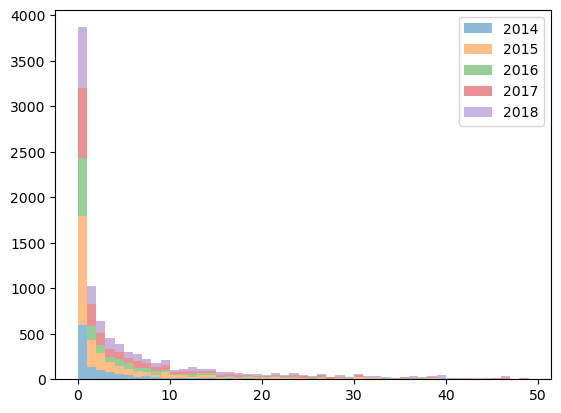

In [95]:
plt.hist(data_to_plot,  alpha=0.5, label=[2014,2015,2016,2017,2018], bins=range(0,50,1), stacked=True, )
plt.legend(loc='upper right')